In [1]:
import sys 
import torch
sys.path.append('../..')

import os
import pytorch_lightning as pl
from src.datasets.vqa_rad_dataset import VQRadDataModule
from src.models.multimodal.flamingo_module import FlamingoModule
from tqdm import tqdm

from pytorch_lightning import Trainer, seed_everything
import torchvision.transforms as T

from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import loggers as pl_loggers

%load_ext autoreload
%autoreload 2

seed_everything(42, workers=True)

img_mean = (0.48,0.48,0.48)
img_std = (0.265,0.265,0.265)

transforms = {'train':
    T.Compose(
    [
        # T.RandomRotation(10),
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ]),
    'val':
    T.Compose(
    [
        # T.RandomRotation(10),
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ]),
    'test':
    T.Compose(
    [
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ])
}


/home/andrei/anaconda3/envs/mlmi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


In [2]:
# Hyperparameters
NUM_DATA_WORKERS  = 8
ONLY_IMAGES = False
BATCH_SIZE = 1
NUM_EPOCHS = 10
LIMIT_NUM_SAMPLES = None

ACCELERATOR = "gpu"
DEVICES = [4]
# ACCELERATOR = "cpu"
# DEVICES = 1
DATASET_ROOT = '/home/andrei/mlmi/home/mlmi-matthias/Data/VQA_RAD_preprocessed/'
PRETRAINED_CLIP_PATH = '/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth'
PRETRAINED_GPT2_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin"

IMAGE_TYPE = "jpg"
SHUFFLE = True
TOKENIZER  = "gpt2"
LOAD_IN_MEM = True
PREPROCESSED = True

vqarad_datamodule = VQRadDataModule(
                                batch_size=BATCH_SIZE, transforms=transforms, root=DATASET_ROOT,
                                limit_num_samples=LIMIT_NUM_SAMPLES, num_workers=NUM_DATA_WORKERS, shuffle=SHUFFLE,
                                tokenizer="gpt2", preprocessed=PREPROCESSED, load_in_memory=LOAD_IN_MEM
)

There are 794 QA pairs in VQA-RAD dataset
Dataset root: /home/andrei/mlmi/home/mlmi-matthias/Data/VQA_RAD_preprocessed/
Loading all images into memory... for train
Found 107 images
Dataset root: /home/andrei/mlmi/home/mlmi-matthias/Data/VQA_RAD_preprocessed/
Loading all images into memory... for val
Found 107 images
Dataset root: /home/andrei/mlmi/home/mlmi-matthias/Data/VQA_RAD_preprocessed/
Loading all images into memory... for test
Found 107 images


In [46]:
train_loader = vqarad_datamodule.train_dataloader()
val_loader = vqarad_datamodule.val_dataloader()
test_loader = vqarad_datamodule.test_dataloader()

In [53]:
# MODEL HPRAMS
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +3 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = vqarad_datamodule.train_dataset.tokenizer.\
    all_special_ids[vqarad_datamodule.train_dataset.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"



print("LANGUAGE_MODEL : ",LANGUAGE_MODEL, "\n"
        "NUM_TOKENS : ",NUM_TOKENS, "\n"
        "FLAMINGO_EMBED_DIM : ",FLAMINGO_EMBED_DIM, "\n"
        "DEPTH : ",DEPTH, "\n"
        "NUM_HEADS : ",NUM_HEADS, "\n"
        "ATT_HEAD_DIM : ",ATT_HEAD_DIM, "\n"
        "CROOS_ATT_EVERY : ",CROOS_ATT_EVERY, "\n"
        "MEDIA_TOKEN_ID : ",MEDIA_TOKEN_ID, "\n"
        "PERCEIVER_NUM_LATENTS : ",PERCEIVER_NUM_LATENTS, "\n"
        "PERCEIVER_DEPTH : ",PERCEIVER_DEPTH, "\n"
        "IMAGE_ENCODER : ",IMAGE_ENCODER, "\n"
        "PRETRAINED_CLIP_PATH : ",PRETRAINED_CLIP_PATH, "\n"
        "PRETRAINED_GPT2_PATH : ",PRETRAINED_GPT2_PATH, "\n")


hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 0,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
}


model = FlamingoModule(**hyperparams)

LANGUAGE_MODEL :  gpt2 
NUM_TOKENS :  50260 
FLAMINGO_EMBED_DIM :  768 
DEPTH :  12 
NUM_HEADS :  8 
ATT_HEAD_DIM :  64 
CROOS_ATT_EVERY :  3 
MEDIA_TOKEN_ID :  50258 
PERCEIVER_NUM_LATENTS :  64 
PERCEIVER_DEPTH :  2 
IMAGE_ENCODER :  clip 
PRETRAINED_CLIP_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth 
PRETRAINED_GPT2_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin 

Pretrained clip is being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156


In [54]:
# CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_MIMICback_lr1e-4_Xray/checkpoints/epoch=5-val_loss=1.35-other_metric=0.00.ckpt"
# CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_MIMICback_all/checkpoints/epoch=59-val_loss=1.48-other_metric=0.00.ckpt"
CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_ROCOback_all/checkpoints/epoch=78-val_loss=1.53-other_metric=0.00.ckpt"

START_FROM_CHECKPOINT = True

if START_FROM_CHECKPOINT:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",CHECKPOINT_PATH)
    model.load_state_dict(torch.load(CHECKPOINT_PATH)["state_dict"])

Pretrained Flamingo Model is loaded from checkpoint :  /home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_ROCOback_all/checkpoints/epoch=78-val_loss=1.53-other_metric=0.00.ckpt


In [55]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from transformers import GPT2Tokenizer
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate(image, context, cur_model, ntok=20):
    for _ in range(ntok):
        out = cur_model({'image': image,'input_ids': context })
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context


tokenizer = vqarad_datamodule.train_dataset.tokenizer

In [7]:
val_loader_iter = iter(val_loader)

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

Model out :  <|endoftext|> <image> question: Where in the image are the calcifications located? answer:? Answer: No <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: High on the image


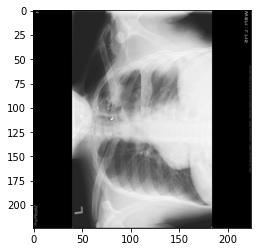

In [9]:
# batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

Model out :  <|endoftext|> <image> question: Are there rib fractures present? answer: No <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: No


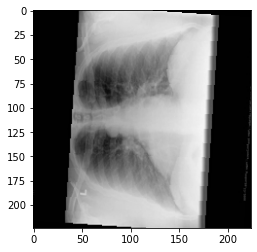

In [38]:
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

In [25]:
val_loader_iter = iter(val_loader)
cos_similarity = torch.nn.CosineSimilarity()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [28]:
from torch import no_grad


def generate_logits(image, pred_context, GT_context, GT_answer, model, ntok):

    # get a prediction (whole answer)
    pred_out_logits = None
    pred_answer = torch.tensor([[]])
    for i in range(ntok):
        out = model({'image': image,'input_ids': pred_context})
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        pred_answer = torch.cat([pred_answer, next_tok.unsqueeze(-1)], dim=-1)
        pred_context = torch.cat([pred_context, next_tok.unsqueeze(-1)], dim=-1)

    with torch.no_grad():
        model.eval()
        # only get embeddings for answer and GT from the model
        answer = tokenizer.decode(pred_answer[pred_answer!=50257].int())                # remove padding tokens, <EOC> token remains
        # print(f'Ans: {answer}')
        pred_answer = torch.tensor([tokenizer.encode("<|endoftext|> " + answer)])
        pred_out_logits = model.forward({'image': image,'input_ids': pred_answer}, return_embeds=True)
        real_out_logits  = model.forward({'image': image,'input_ids': GT_answer}, return_embeds=True)

    return pred_context, pred_out_logits, real_out_logits, answer

In [30]:
batch = next(val_loader_iter)
val_img = batch["image"]
pred_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ batch["question"][0] + ' answer:')]) 
GT_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ batch["question"][0] + ' answer: ' + batch["answer"][0] + '<EOC>')])
GT_answer =  torch.tensor([tokenizer.encode("<|endoftext|> " + batch["answer"][0] + ' <EOC>')])
out, pred_out_logits, real_out_logits, answer = generate_logits(val_img, pred_context, GT_context, GT_answer, model, ntok=20)

print("Model out : ",tokenizer.decode(out[out != 50257]))
print("Correct Answer: " + batch["answer"][0])

print(f'Answer: {tokenizer.encode(answer[:-1])}')

pred = torch.mean(pred_out_logits, dim=1)
real = torch.mean(real_out_logits, dim=1)

torch.nn.functional.cosine_similarity(pred, real)

Model out :  <|endoftext|> <image> question: is there evidence of intraparenchymal lung nodules? answer: yes in this chest x xray? Answer: X 5th <EOC>
Correct Answer: No
Answer: [3763, 287, 428, 7721, 2124, 2124, 2433, 30, 23998, 25, 1395, 642, 400, 1279, 36, 4503]


tensor([0.8924])

data: (286, 768)
labels: torch.Size([286])


<AxesSubplot:>

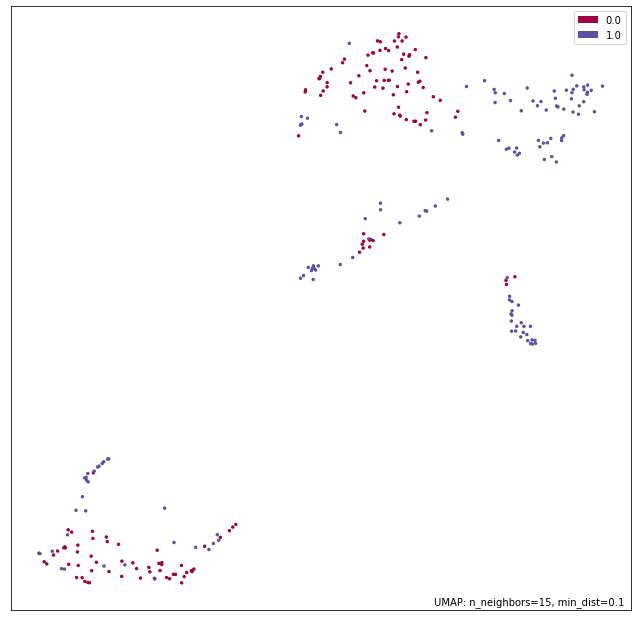

In [55]:
import umap
import umap.plot

reducer = umap.UMAP()
data = torch.cat([preds, reals], dim=0).detach().numpy()
labels = torch.cat([torch.zeros(preds.shape[0]), torch.ones(reals.shape[0])])
# data = torch.tensor(preds)
print(f'data: {data.shape}')
print(f'labels: {labels.shape}')
mapper = reducer.fit(data)
umap.plot.points(mapper, labels=labels)

In [56]:
# do validation dataset eval
val_loader_iter = iter(val_loader)
n = len(val_loader)
print(f'validation dataset has {n} samples')

preds = torch.tensor([])
reals = torch.tensor([])

similarity_num = 0
identical_num = 0

for sample in val_loader_iter:
    val_img = sample["image"]
    pred_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer:')]) 
    GT_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer: ' + sample["answer"][0] + '<EOC>')])
    GT_answer =  torch.tensor([tokenizer.encode("<|endoftext|> " + sample["answer"][0] + ' <EOC>')])
    out, pred_out_logits, real_out_logits, answer = generate_logits(val_img, pred_context, GT_context, GT_answer, model, ntok=20)

    pred = torch.mean(pred_out_logits, dim=1)
    real = torch.mean(real_out_logits, dim=1)

    ans = answer.replace('<EOC>','')
    # print(f'gt {sample["answer"][0].strip()}\npred: {ans.strip()}')

    if sample["answer"][0].strip().lower() == ans.strip().lower():
        identical_num += 1

    similarity = cos_similarity(pred, real)
    if similarity.detach().numpy()[0] > 0.95:
        print("Model out : ",tokenizer.decode(out[out != 50257]))
        print("Correct Answer: " + sample["answer"][0])
        similarity_num += 1
        if similarity_num % 10 == 0:
            print(f'Another 10..')
        preds = torch.cat([preds,pred], dim=1)
        reals = torch.cat([reals,real], dim=1)

print(f'There were {similarity_num} TPs out of {n}')
print(f'There were {identical_num} identi cal answers out of {n}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [57]:
# do validation dataset eval
test_loader_iter = iter(test_loader)
n = len(test_loader)
print(f'validation dataset has {n} samples')

preds = torch.tensor([])
reals = torch.tensor([])

similarity_num = 0
identical_num = 0

for sample in test_loader_iter:
    val_img = sample["image"]
    pred_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer:')]) 
    GT_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer: ' + sample["answer"][0] + '<EOC>')])
    GT_answer =  torch.tensor([tokenizer.encode("<|endoftext|> " + sample["answer"][0] + ' <EOC>')])
    out, pred_out_logits, real_out_logits, answer = generate_logits(val_img, pred_context, GT_context, GT_answer, model, ntok=20)

    pred = torch.mean(pred_out_logits, dim=1)
    real = torch.mean(real_out_logits, dim=1)

    ans = answer.replace('<EOC>','')
    # print(f'gt {sample["answer"][0].strip()}\npred: {ans.strip()}')

    if sample["answer"][0].strip().lower() == ans.strip().lower():
        identical_num += 1

    similarity = cos_similarity(pred, real)
    if similarity.detach().numpy()[0] > 0.95:
        # print("Model out : ",tokenizer.decode(out[out != 50257]))
        # print("Correct Answer: " + sample["answer"][0])
        similarity_num += 1
        if similarity_num % 10 == 0:
            print(f'Another 10..')
        preds = torch.cat([preds,pred], dim=1)
        reals = torch.cat([reals,real], dim=1)

print(f'There were {similarity_num} TPs out of {n}')
print(f'There were {identical_num} identi cal answers out of {n}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 